In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from brian2 import *

### A SINGLE NEURON

Spike times: [16. 37. 58.] ms


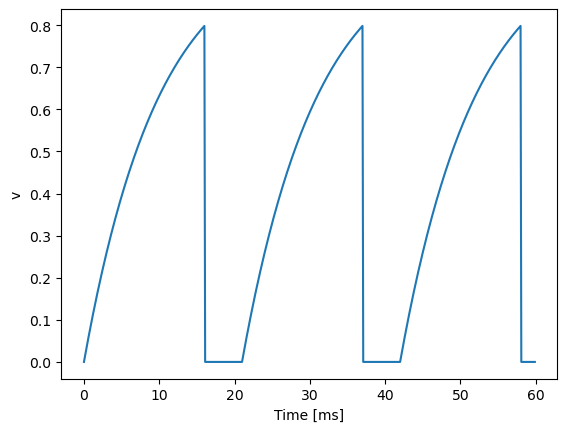

In [2]:
"""
A SINGLE NEURON

eqs are string with one line per equation. ': 1' suffix means it is unitless.
Dimensions must always be specified and consistent in equations.
"""
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau: 1 (unless refractory)
'''

# threshold and reset can be replaced by any expression or series of statements
G = NeuronGroup(1, eqs, threshold= 'v>=0.8', reset='v=0', refractory = 5*ms, method='exact')
M = StateMonitor(G, 'v', record=0)

spikemon = SpikeMonitor(G)

run(60*ms)
plot(M.t/ms, M.v[0])
xlabel('Time [ms]')
ylabel('v')

print(f"Spike times: {spikemon.t[:]}")

### MULTIPLE NEURONS

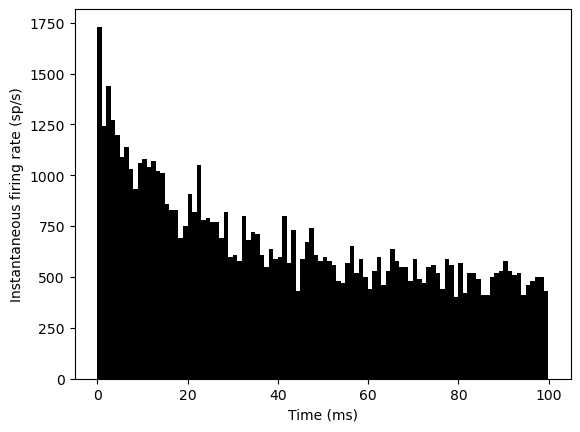

In [3]:
start_scope()


N = 1000
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

# Noisy neuron with a variable threshold
eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

# reset rule for all variables
reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
M_v = StateMonitor(G, 'v', record = 0)

spikemon = SpikeMonitor(G, record = True)

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)


_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=list(ones(len(spikemon))/(N*defaultclock.dt)))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');


### SYNAPSES

WARNING    'tau' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


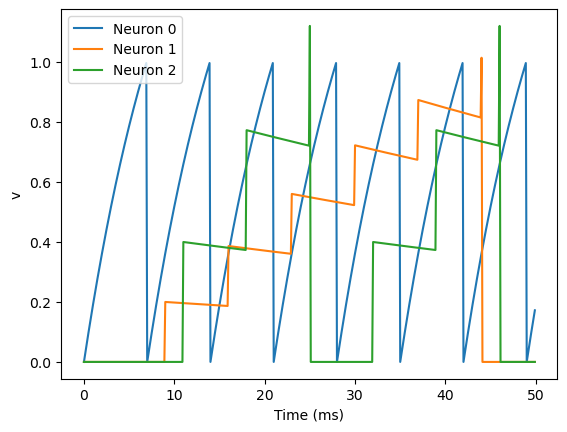

In [4]:
start_scope()


eqs = '''
dv/dt = (I - v)/tau : 1
I : 1
tau : second
'''

G = NeuronGroup(3, eqs, threshold='v>1', reset='v=0', method='exact')

# Initialise multiple parameters with arrays... This is how I will have to do it for AQUA
G.I = [2, 0, 0]        # neuron 2 receives no driving except for the synapse
G.tau = [10, 100, 100]*ms

# Define synapses
S = Synapses(G, G, 'w: 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])     # connect neurons
S.w = 'j*0.2'   # synaptic weight
S.delay = 'j*2*ms'
# for more complex connectivity conditions...
# S.connect(condition= 'i!=j', p = 0.2)
# or S.connect(condition= 'abs(i-j)<4 and i!= j')

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend()

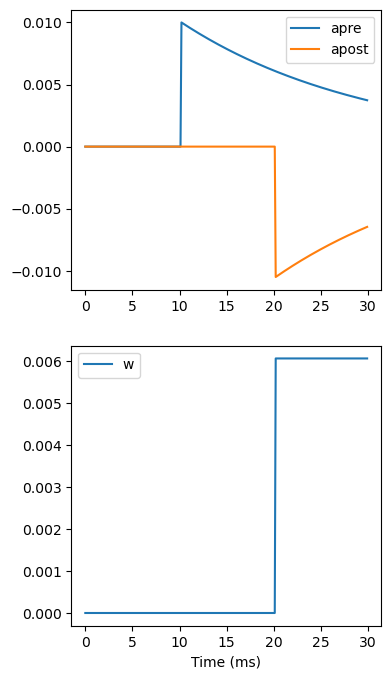

In [5]:
""" - - - - STDP - - - - """
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

### Tutorial 3: Experimental Simulations

Includes more complicate scenarios likely to be part of research simulations such as inputting sensory data, modelling experimental conditions, etc ...

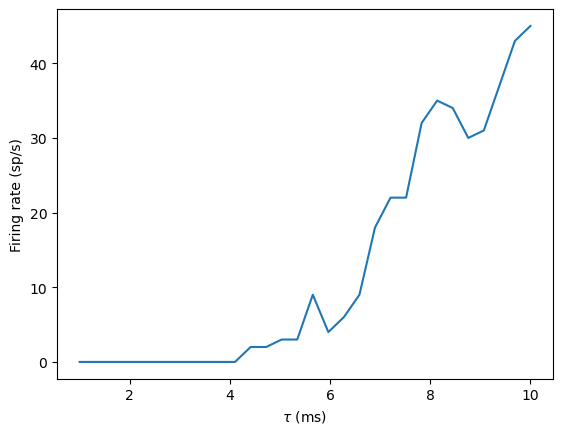

In [6]:
"""- - - - MULTIPLE RUNS - - - - 

Can use store() and restore() to save re-initialising a network.
These are also useful once a network has been trained and you want to 
run multiple test runs on the trained network.

"""


start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)

store()     # Store the current state of the network
for tau in tau_range:
    restore()       # Restore the original state of the network
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

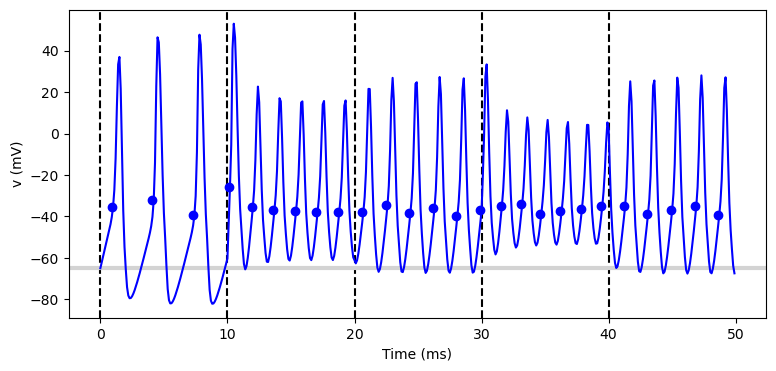

In [7]:
""" - - - - HH-type neuron with varying input - - - - 

run_regularly() will run the specified code (i.e. change in amplitude current here)
every dt=10*ms timesteps in the simulation. This saves creating a for-loop.

Alternatively, @network_operation allows you to run more general python code

"""
start_scope()
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp (shared)
'''
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
# we keep the loop just to draw the vertical lines
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');